# Text Classification with TF-IDF, LSTM, BERT: a comparison of performance

While looking for information to solve a text classification problem, I could find various descriptions on how to do it; but I was missing a comparison with measurable metrics, showing the pros and cons of various methods.

## Introduction

The objective of this article is to provide quantitative comparison of the algorithms, provide the Python code to make it, and basic explanations on what is being done.

The algorithms will be analysed using two metrics: accuracy and running time (for learning).

We will go over three text classification approaches, increasing in complexity and following the historical developments. First, we will use a "traditional" machine learning method, applying a linear model on the TF-IDF approach. Then we will go deep learning. We will first use a Recurrent Neural Network (RNN) method and encode words using the algorithm Word2Vec. This is a way of using pre-learned information. Finally, we will use the model BERT (or a simplified version of it, distil-BERT) and fine-tune it on our specific classification task. This approach allows the use of a pre-learned algorithm, which encodes not only words but entire sentences.

Note that we will use a very basic accuracy calculation. More sophisticated approaches (f-score, macro-average) would make more sense. But the goal of this article is to better understand classification models, not accuracy scores.

Before starting, we need to get the libraries:

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
import matplotlib
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim
import gensim.downloader as api

# Various
from datetime import datetime

# Showing the versions used
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('PyPlot version: {}'.format(matplotlib.__version__))
print('Scikit Learn version: {}'.format(sklearn.__version__))
print('Tensorflow version: {}'.format(tf.__version__))
print('Transformers version: {}'.format(transformers.__version__))
print('Regex version: {}'.format(re.__version__))
print('NLTK version: {}'.format(nltk.__version__))
print('Gensim version: {}'.format(gensim.__version__))

Pandas version: 1.2.4
Numpy version: 1.19.5
PyPlot version: 3.3.4
Scikit Learn version: 0.24.1
Tensorflow version: 2.5.0
Transformers version: 4.15.0
Regex version: 2.2.1
NLTK version: 3.6.1
Gensim version: 4.1.2


## Get and Process the Data

In this article we will consider two datasets (long texts and short texts):
- BBC news, classified by topic: https://www.kaggle.com/sainijagjit/bbc-dataset
- Tweets related to Corona, classified by sentiment (5 levels): https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

We will use the BBC news throughout this article, but the same applies to the tweets dataset. The detailed analysis below relates to the BBC news use case. A detailed analysis of the Corona corpus might lead to different conclusions, given its complexity is higher and the dataset is larger.

Note that the BBC news corpus contains around 2k entries, and the Corona Tweets contain around 40k. The first dataset is therefore much faster and can be run on a standard computer, while the second dataset cannot.

In [2]:
# Select the dataset for the analysis

dataset = 'bbc-text' # select 'bbc-text' or 'corona'

In [3]:
if dataset=='bbc-text':
    datapath = "data/bbc-text.csv"
if dataset=='corona':
    datapath="data/Corona_NLP_train.csv"

df = pd.read_csv(datapath)

if dataset=='corona':
    df.rename(columns={"Sentiment": "category", "OriginalTweet": "text"}, inplace=True)

df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


### Analyze Data

Let's look at what we get.

In [4]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["category"].value_counts())
print(40*'-')
nr_categories = len(df["category"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 2225
----------------------------------------
Split by category:
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
----------------------------------------
Number of categories: 5


We get a total number of entries of 2'225, which are relatively evenly split across five categories.

In case the split across categories is imbalanced, there are techniques to "correct" this by over-weighting the data with an under-represented category. For this, you can refer to: https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

Finally, let's look at a specific example to get a concrete impression:

In [5]:
# You can adjust n:
n=100
print('Category: ',df['category'][n])
print(100*'-')
print('Text:')
print(df['text'][n])

Category:  entertainment
----------------------------------------------------------------------------------------------------
Text:
housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-chann

### Prepare Data

Some algorithms (RNN and based on BERT) are fed with the original text. But for the TF-IDF algorithm we need to pre-process the data.

We pre-process the data with the help of specialized libraries. We introduce a function that will allow to:
- convert to lower cases, remove special characters, ...
- tokenize (i.e. convert from strings to lists of words)
- remove stopwords (i.e. remove common words that bring noise to the system, like 'a', 'the', ...)
- stemm (i.e. remove -ing, -ly, ..., like convert 'making' to 'make', so that words with same meaning are identified as being the same)
- lemmatize (i.e convert the word into a root word, for example 'feet' becomes 'foot')

In [6]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk (that is used in the function below)
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
# Let's apply this function to the whole corpus
df["text_clean"] = df["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,category,text,text_clean
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


The pre-processing makes the text less readable for a human but more readable for a machine!

### Split into Train and Test data

As a next step, in order to assess the accuracy of the algorithm, we need to split the dataset into a training dataset (to train the model) and a test dataset (to assess the model). This is done with standard tools. We split 70/30, as is standard for relatively small datasets.

We rename the input (text) to X and the output (category) to y, to be aligned with standard notations in machine learning.

The dataset is relatively small. Therefore it makes sense to create training/test sets that are representative of the dataset. We do it by splitting such that the number of dataset per category is similar. To understand this, think about forecasts for an election: you also need to take a sample that is representative of the population (representative by gender, age, ...)

In [8]:
# Renaming, Input -> X, Output -> y
X = df['text_clean']
y = df['category']

In [9]:
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['category'])

Let's look at the split by category: you can see that both the training and test sets are representative of the dataset.

In [10]:
y_train.value_counts()/y.value_counts()

business         0.700000
entertainment    0.699482
politics         0.700240
sport            0.698630
tech             0.700748
Name: category, dtype: float64

## TF-IDF Model

The TF-IDF model (Term Frequency - Inverse Document Frequency) models a text by counting how often a word (called uni-gram), or a combination of two words (two successive words, called bi-gram), or even more (n-gram), appears in the text. This leads to the "term frequency". It is then divided by the document frequency, which counts how often a word appears across all entries (i.e. all documents). The last step allows to underweight words which appear more often, and overweight words which appear rarely.

The TF-IDF model does not take into account the order of the words (except for two successive words) and belongs therefore to the family of models called "Bag of Words". We will see later models which take the order of words into account.

To convert text into this format, we "vectorize" the text into a vector. When doing this we specify the size of the vocabulary (i.e. the total number of words taken into consideration), and the n-gram range. Then a word (and a word pair in case of bi-grams) is represented by a vector of the size of the vocabulary and has values in only one element, the others being all zero. This is called a one-hot vector.

After having initialized the vectorizer, we fit it on the entire training set.

In [11]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

Let's build the model. After an entry is converted to a vector using the vectorizer, we apply an algorithm that minimizes the error, i.e. the output predicted by the model y(X) should be as often as possible equal to the label y.

We use the logistics regression. Other models could also be applied (like SVM, Naive Bayes, ...).

We build the model as a pipeline, consisting of:
- vectorization
- classifier

After initialization of the model, we fit it to the training data.

In [12]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

After the model is trained, we assess the accuracy of the model by comparing the predictions of the model to the labels for both the training and the test data. We compare it for both as the difference between the two accuracies is an important indicator of overfitting (i.e. the model is too strongly fitted to the training data).

We also look at the duration of the training.

In [13]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 99.7%
Accuracy Test data: 97.9%
Training time: 1.8s


We get an amazing accuracy! Both training and test accuracy are similar, so the model is not overfitted. If the model were overfitted, it could be improved by adjusting the regularization, which comes by default with the sci-kit logistic regression model. A typical regularization mechanism is the L2 regularization, which is not covered in this article. And we got it in less than 3 seconds!

Before moving to deep learning, we would like to add a few comments on the Logistic Regression model. This model is to classification what linear regression is to regression. It is a linear model. This means that the minimization algorithm consists of minimizing a function which is quadratic in its parameters. The great news is that such a minimization has no local minima, but only a global minimum, which can be reached. And it can be reached using a simple and fast algorithm, by inverting a matrix (of the size of the vocabulary). The negative side is that once this minimum is reached, it is difficult to improve the model (except by adding regularization).

The conclusion is that the linear algorithm are converging fast and reach the "exact" solution, however once a model is optimized, there is little room for improvement.

### Model Interpretation

An advantage of the linear algorithm is that we can interpret its result easily. Since each parameter of the model corresponds to a word, knowing which parameters count most automatically tells us which words count most.

Let's have a closer look at the model's parameters, extracting the ten most important words per category:

In [14]:
print('Classes of the model: ',classifier_tfidf.classes_)
print(80*'-')
print('Shape of the coefficients of the model (categories x vocabulary size): ',classifier_tfidf.coef_.shape)
print(80*'-')
NN = 10
# Get the 10 (here: NN, which you can adjust yourself) ids of the words with highest weights per category
top_words = np.argsort(classifier_tfidf.coef_,axis=1)[:,-NN:]

# Get the vocabulary of the model (mapping of words to ids):
voc = vectorizer_tfidf.vocabulary_
# Get the inverse vocabulary to map the ids of the words to the words:
inv_voc = {v: k for k, v in voc.items()}

# Get for each category (=class) the top ten words
for n, w in enumerate(classifier_tfidf.classes_):
    t = w + ': '
    for i in range(NN):
        t += inv_voc[top_words[n,i]]
        if i!=NN:
            t+=', '
    print(t)
    print(80*'-')

Classes of the model:  ['business' 'entertainment' 'politics' 'sport' 'tech']
--------------------------------------------------------------------------------
Shape of the coefficients of the model (categories x vocabulary size):  (5, 15000)
--------------------------------------------------------------------------------
business: economy, economic, price, growth, profit, market, bank, firm, share, company, 
--------------------------------------------------------------------------------
entertainment: chart, tv, singer, album, band, star, award, music, show, film, 
--------------------------------------------------------------------------------
politics: mp, blair, tory, lord, minister, election, government, labour, mr, party, 
--------------------------------------------------------------------------------
sport: team, season, england, coach, win, champion, cup, player, club, match, 
--------------------------------------------------------------------------------
tech: online, site, 

The model seems to work well!

## Deep Learning - RNN

Words appear in a text in a given order. Recurrent Neural Networks (RNN) are models which take the order of words into account, by processing words sequentially, as they appear in the text. It was observed that RNNs, without any "internal memory", have a limitation regarding "how far they can remember" the effect of correlations between words. To mitigate this, Long Short Term Memory (LSTM) cells replaced the traditional RNNs in Machine Learning. The LSTM cells have internal variables which act as a memory. It comes at a slightly higher computational costs, which is typically acceptable.

In the building of this model, we take advantage of word embeddings, applying Word2Vec. This is a technique that was published in 2013 [1] and had a considerable impact in NLP. It consists of describing a word with a vector of a given size (typically 100 or 300). The vector for a given word is defined by its context within texts (i.e. based on words on its left and its right - N words on the left, N words on the right, N being typically 5). Typically, word embeddings is trained on huge text corpuses. Word2Vec was trained on millions of Google News, while a similar technique called GloVe was trained on Wikipedia. Words with similar meanings (synonyms) are typically close to each other in this space of words. The representation is "dense", compared to the one-hot vector representation, which is "sparse".

The sequential approach of RNN enables to take the order of words into account, but at the same time slows down the training, since a sequential approach by design cannot be handled by parallel computing.

Training and test data is defined in a different way than for TF-IDF: we will use the non-processed text. The labelling cannot be handled as text but has to be converted into a one-hot vector, because of technical reasons (to the best of my knowledge, this is simply not implemented in TensorFlow). Then we split into training and test data, same as we did for TF-IDF.

In [15]:
# Renaming, Input -> X, Output -> y
X_tf = df['text']
y_tf_class = df['category']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_tf_class)
y_tf = lab.transform(y_tf_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + y_tf_class[n] + ' is ', y_tf[n])

# Split into training and test data
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, random_state=42, stratify=df['category'])

Coding of labels into a one-hot vector: entertainment is  [0 1 0 0 0]


The text, a sequence of words, needs to be converted to a sequence of numbers. We tokenize the text using TensorFlow's tokenizer.

After initializing the tokenizer, we fit it on the training data.

In [16]:
corpus = X_tf_train
max_words = 15000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

Let's use the tokenizer to convert the training data (a sequence of words) into a sequence of numbers representing the words. We then pad sequences using TensorFlow's pad_sequences. We define a limit to the length of the sequences. Any text with more words than allowed will be cut.

We look at the shape of the training data after processing it, and illustrate it with a specific example.

In [17]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (1557, 200)
----------------------------------------------------------------------------------------------------
Example:  [    4   317  1408  1309   651     3  4599   148    62   229    28  3974
   472     7   540     6  2012  1398   471 10401     6   574     4   198
     2   530     8   320    15  2160   265    56   409  1624     5     2
  4600  4601  2717     2  4881    14     2   198    15  1556    24     6
  1093   302     7     2    49  1575    34  8961     6   381    41     8
  1408   218    13     2  4881   304    14   477     4     2  4881     9
   860   581   112    52    10  1324  5208   823    13   416     2   457
     4   446    10  3619     5  2248     1     7     2   242  2161     2
  4881     9  1656     4   317  1408  1309    10  3793    28  1736  5598
     4  7138  1459    22    40    56  2362  1971   230  3487    28  6032
     3  6033     3  1625     5    20    73    39  1398   471   163   890
   238   409   180   320     9  1092     3   193     7    22  4599

Each word is now represented by a number (an index). We want to represent it by a vector which represents it best, leveraging on pre-learned information.

This is done using Word2Vec, which we have described above. We will not train ourselves this word representation but download an existing representation, from the library gensim. This may take several minutes. Once this word representation is available, we map it to our tokenization.

In [18]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape

(300,)

In [19]:
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

After we have a word representation, we build the model. We use:
- Input layer: to tell the model which input format to expect, so that the model knows what to expect
- Embedding: we transform the input (a sequence of word indices) into a sequence of embedded words (a sequence of vectors of size 300), using the downloaded Word2Vec matrix
- LSTM layer: we use an LSTM layer that goes in both directions (forward and backward), to have maximal information available. The output of this layer (that is pushed to the next layer) is the output of the last word (on the right for the forward LSTM, on the left for the backward LSTM). We set the size of the output vector to 15 (which is somewhat arbitrary). Combining both outputs (forward and backward), we get a vector of size 30
- Dropout layer: for regularization
- Dense layer (with relu activation function, with 64 neurons): to solve the specific problem of classification
- Dense layer (with softmax activation function): for a probability distribution for each label

We run the model using Adam optimizer, where we have played with the hyper-parameters. Based on the recommendations of the first article on dropout (2014) [2|, we increase the learning rate compared to TensorFlow's default values.

In [20]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

Let's look at the model:

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 300)          4500300   
_________________________________________________________________
bidirectional-lstm (Bidirect (None, 30)                37920     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
classification (Dense)       (None, 5)                 325       
Total params: 4,540,529
Trainable params: 40,229
Non-trainable params: 4,500,300
______________________________________________

Now it is time to train the model! We train it over 10 epochs. When training the model, we get from the history object precious information, that we display after the training.

In [22]:
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10
25/25 [==============================] - 7s 153ms/step - loss: 1.2407 - accuracy: 0.4888 - val_loss: 0.6917 - val_accuracy: 0.7350
Epoch 2/10
25/25 [==============================] - 3s 117ms/step - loss: 0.7127 - accuracy: 0.7328 - val_loss: 0.5307 - val_accuracy: 0.8234
Epoch 3/10
25/25 [==============================] - 3s 118ms/step - loss: 0.4145 - accuracy: 0.8664 - val_loss: 0.4044 - val_accuracy: 0.8653
Epoch 4/10
25/25 [==============================] - 3s 118ms/step - loss: 0.3530 - accuracy: 0.8773 - val_loss: 0.2816 - val_accuracy: 0.9117
Epoch 5/10
25/25 [==============================] - 3s 117ms/step - loss: 0.2113 - accuracy: 0.9300 - val_loss: 0.3067 - val_accuracy: 0.9162
Epoch 6/10
25/25 [==============================] - 3s 118ms/step - loss: 0.1576 - accuracy: 0.9403 - val_loss: 0.2761 - val_accuracy: 0.9251
Epoch 7/10
25/25 [==============================] - 3s 122ms/step - loss: 0.1579 - accuracy: 0.9505 - val_loss: 0.2390 - val_accuracy: 0.9296
Epoch 

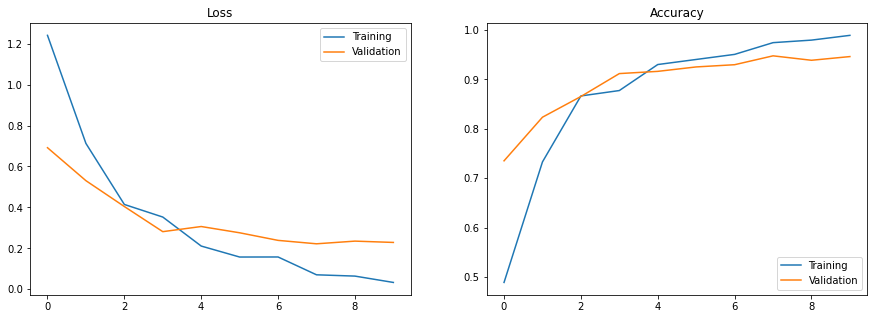

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [24]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 98.9%
Accuracy Test data: 94.6%
Training time: 33.2s


For this (simple) problem with little training data, we observe that this sophisticated model gets a lower accuracy than the TF-IDF model, and needs around 10 times more time to be trained!

This might be disappointing. My conclusion is:  a simple problem does not necessarily needs a sophisticated solution.

The Recurrent Neural Network model with the use of Word2Vec was improved from the Linear TF-IDF model by taking the order of words into consideration, and by using a pre-learned representation of words. But the representation of words we have does not consider the context in which the word is applied. For example, in the following sentences: "I took a loan at the bank.", "I am sitting on a bank.", the word "bank" has a completely different meaning. It is reasonable to think that teh context matters. This is what the model BERT is solving.

## Deep Learning - With Bert Language Model

Going one step further, let's introduce a model where not only each single words are pre-learned, but entire sentences. This is achieved with the BERT language model, which was published in 2019 by Devlin et al [3], at Google. This language model allows the encoding of words depending on their context, by using a huge corpus (Wikipedia and books) for training. Training is done as self-supervised: it is done by masking randomly words from existing sentences. The training of the model consists of completing the missing words. The architecture of BERT consists of multiple layers of transformers.
The BERT model has 110m parameters; the large Bert model has 340m parameters. In practice, we will use a smaller model, Distil Bert, which has 66m parameters.
Devlin at al. made the implementation of the BERT model available (https://github.com/google-research/bert). But we will use the Python library transformers, which was made available by company HuggingFace (together with many other models).

Since the BERT model is pre-trained, it comes with a tokenizer. This is why we will use the non-processed training data, and will tokenize the sentences using the Distil Bert tokenizer. As for the RNN model, we will have to map the labels to a one-hot vector.

For practical reasons, we will first convert the training data into the desired format, and later we will split into training/test data.

The Distil BERT model requires a sequence of word indices and an attention mask (a sequence of attention values). This is also what the Distil Bert tokenizer generates. But for our simple use case, the attention mask will be constant. This is why, when building the data, we will ignore the attention mask and only consider the word indices (which are the "input_ids" of the Distil Bert tokenizer). For performance reasons, we convert the list of training data into an array.

In [25]:
# Renaming, Input -> X, Output -> y
X_bert = df['text']
y_bert_class = df['category']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_bert_class)
y_bert = lab.transform(y_bert_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + y_bert_class[n] + ' is ', y_bert[n])

Coding of labels into a one-hot vector: entertainment is  [0 1 0 0 0]


In [26]:
# distil-bert tokenizer
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_bert = [tokenizer_bert(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in X_bert]
X_bert = np.array(X_bert, dtype='int32')

Let's split the data into a training and a test set, and have a look at the format of the data.

In [27]:
# Train/test split
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert, y_bert, test_size=0.3, random_state=42, stratify=df['category'])
print('Shape of training data: ',X_bert_train.shape)

Shape of training data:  (1557, 512)


Let's define the Distil Bert model, using a pre-trained model from the transformers library. This model will be integrated as a layer in the classification model. We will not train the parameters of this layer, which we do by setting it as trainable=False.

In [28]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


You might get a warning message. Don't worry about it. In the context where we apply the model, this message can be ignored.

Let's have a closer look at the output of this model. For this, let's take a sample from our training dataset (we take a sample of size five) and look at the output through the model.

In [29]:
# Let's create a sampe of size 5 from the training data
sample = X_bert_train[0:5]
print('Object type: ', type(dbert(sample)))
print('Output format (shape): ',dbert(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
Output format (shape):  (5, 512, 768)
Output used as input for the classifier (shape):  (5, 768)


The output is a specific Python object. Among other information, we get a Tensor of size (N, M, S), where N is the size of the dataset (in our case five examples), M is the length of the sample (number of words in a sentence), and S is the size of the output vector (the output of the model). Typically, as mentioned by Devlin et al., for a classification task, we use the first output vector of a sentence as input for the rest of the classification model, since this first vector "encodes" information on the overall sentence. Alternatively a pooling of all output vectors could also be used as input for the rest of the classifier.

It is now time to build the classification model! It consists of:
- Input layer: to tell the model which input format to expect, so that the model knows what to expect
- Distil Bert model: to encode the input data into a new sequence of vectors (that is the output of BERT). Only the first vector of this sequence will be used as an input for the rest of the classifier
- Dropout layer: for regularization
- Dense layer (with relu activation function, with 64 neurons): to solve the specific problem of classification
- Dense layer (with softmax activation function): for a probability distribution for each label

In [30]:
input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')

x = dbert(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(5, activation='softmax', name='classification')(x)

dmodel = models.Model(inputs=input_ids_in, outputs = x)

dmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [31]:
dmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_token (InputLayer)     [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                49216     
_________________________________________________________________
classification (Dense)       (None, 5)                 325       
Total params: 66,412,421
Trainable params: 49,541
Non-trainable params: 66,362,880
__________________________________________

In [32]:
# Train the model
start_time = datetime.now()
history = dmodel.fit(X_bert_train, y_bert_train, batch_size=32, shuffle=True, epochs=5, validation_data=(X_bert_test, y_bert_test))
end_time = datetime.now()

training_time_bert = (end_time - start_time).total_seconds()

Epoch 1/5
49/49 [==============================] - 763s 15s/step - loss: 0.9259 - accuracy: 0.6969 - val_loss: 0.3141 - val_accuracy: 0.9356
Epoch 2/5
49/49 [==============================] - 792s 16s/step - loss: 0.2860 - accuracy: 0.9364 - val_loss: 0.1848 - val_accuracy: 0.9476
Epoch 3/5
49/49 [==============================] - 834s 17s/step - loss: 0.1997 - accuracy: 0.9493 - val_loss: 0.1416 - val_accuracy: 0.9536
Epoch 4/5
49/49 [==============================] - 836s 17s/step - loss: 0.1613 - accuracy: 0.9576 - val_loss: 0.1328 - val_accuracy: 0.9506
Epoch 5/5
49/49 [==============================] - 833s 17s/step - loss: 0.1333 - accuracy: 0.9672 - val_loss: 0.1029 - val_accuracy: 0.9656


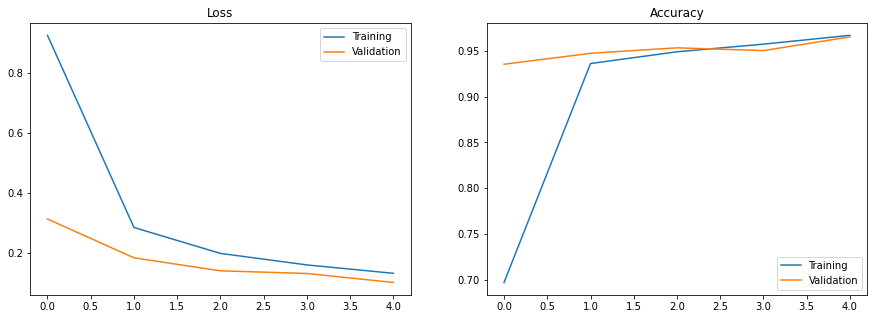

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [34]:
accuracy_bert = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_bert, training_time_bert/60))

Accuracy Training data: 96.7%
Accuracy Test data: 96.6%
Training time: 4058.1s (or 67.6 minutes)


For this (simple) problem with little training data, we observe that this sophisticated model gets a lower accuracy than the TF-IDF model, and needs more than 2'000 times more time to be trained!

This might be disappointing. Same as for the RNN model, my conclusion is: a simple problem does not necessarily needs a sophisticated solution.

## Conclusion

We have gone through three Machine Learning models to classify news according to their category. We have increased the complexity of the models, starting with a "classical" machine learning model, a linear model using TF-IDF. Then we have used a Recurrent Neutral Network model, using word embeddings to make use of pre-learned information. Finally we have used a BERT model, which is a pre-trained model, having not only single words pre-trained but also entire sentences.
The models used are:
- Linear model TF-IDF
- Bi-directional LSTM model with word2vec word embedding
- Distil BERT

We have measured these models using two metrics:
- Acurracy
- Training time
Let's look at the results:

In [79]:
method = ['TF-IDF', 'RNN', 'BERT']
accuracy = [accuracy_tfidf, accuracy_rnn, accuracy_bert]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [round(training_time_tfidf,1), round(training_time_rnn,1), round(training_time_bert,1)]
training_time_rounded = [round(tt,1) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list(training_time /min(training_time))
training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

,Method,Accuracy,Training Time [s],Training Time [x]
0,TF-IDF,97.9%,1.8,1.0x
1,RNN,94.6%,33.2,18.4x
2,BERT,96.6%,4058.1,2254.5x


This classification is a simple problem. A simple model like the linear TF-IDF model already provides a very good accuracy. Using more complex models does not improve accuracy, but costs much more time: the RNN model needs 20 times more time than the TF-IDF. The BERT model needs even more than 1'000 times more time than the TF-IDF!

My conclusion is: it is not always necessary to use complex models, if simple models already solve the issue!

As a side note: the Linear TF-IDF approach can be very frustrating, if we do not get a satisfying accuracy from the beginning. In such cases it can be very hard to improve the model. It is very different with RNN and BERT models. Such models can be easily improved: one can either develop a more sophisticated architecture of the model, or run the model on more epochs, ... For the BERT model, it is fascinating to see that at each epoch, the accuracy improves. One might feel that the model reads the text better and better.

## References

[1] Mikolov, Tomas, et al. (2013). "Efficient Estimation of Word Representations in Vector Space"

[2] Srivastava, Hinton et al. (2014). "Dropout: A Simple Way to Prevent Neural Networks from Overfitting"

[3] Devlin et al. (2019). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"